<a href="https://colab.research.google.com/github/PayalRathod10/image-sharpness/blob/main/sharpeness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision opencv-python tqdm scikit-image matplotlib
!pip install -U scikit-image --quiet
!pip install --upgrade scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# PHASE 1: Setup & Dataset Download
!pip install opencv-python scikit-image einops --quiet
import os, zipfile, glob, cv2, requests
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import Image

# Paths
BASE_DIR = "/content/sharpness_data"
HR_DIR = os.path.join(BASE_DIR, "HR")
LR_DIR = os.path.join(BASE_DIR, "LR")

os.makedirs(HR_DIR, exist_ok=True)
os.makedirs(LR_DIR, exist_ok=True)

# 100 images from DIV2K (HR)
DIV2K_URL = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
zip_path = "/content/DIV2K_train_HR.zip"

if not os.path.exists(zip_path):
    print("Downloading DIV2K subset...")
    r = requests.get(DIV2K_URL, stream=True)
    with open(zip_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk: f.write(chunk)
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")

# Preprocess images: Simulate blur
for img_path in tqdm(sorted(glob.glob("/content/DIV2K_train_HR/*.png"))[:100]):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))           # normalize
    degraded = cv2.GaussianBlur(img, (5,5), 1)  # blur

    fname = os.path.basename(img_path)
    cv2.imwrite(os.path.join(HR_DIR, fname), img)
    cv2.imwrite(os.path.join(LR_DIR, fname), degraded)

print("✅ Data ready: 100 LR-HR image pairs created.")


Extracting...


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]

✅ Data ready: 100 LR-HR image pairs created.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SharpnessDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_paths = sorted(glob.glob(os.path.join(lr_dir, "*.png")))
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, "*.png")))
        self.tf = transforms.ToTensor()

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = self.tf(Image.open(self.lr_paths[idx]).convert('RGB'))
        hr = self.tf(Image.open(self.hr_paths[idx]).convert('RGB'))
        return lr, hr

dataset = SharpnessDataset(LR_DIR, HR_DIR)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

class SharpResNet(nn.Module):
    def __init__(self, blocks=5):
        super().__init__()
        self.entry = nn.Conv2d(3, 64, 3, padding=1)
        self.resblocks = nn.Sequential(*[ResidualBlock(64) for _ in range(blocks)])
        self.exit = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x):
        x = self.entry(x)
        x = self.resblocks(x)
        x = self.exit(x)
        return x


In [ ]:
from torchvision.models import vgg16, VGG16_Weights

# VGG-based perceptual loss
vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features[:16].eval().cuda()
for p in vgg.parameters():
    p.requires_grad = False

def perceptual_loss(pred, target):
    return F.mse_loss(vgg(pred), vgg(target))

# Custom SSIM loss
def gaussian(window_size, sigma):
    gauss = torch.Tensor([np.exp(-(x - window_size//2)**2 / float(2*sigma**2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D = gaussian(window_size, 1.5).unsqueeze(1)
    _2D = (_1D @ _1D.t()).float().unsqueeze(0).unsqueeze(0)
    return _2D.expand(channel, 1, window_size, window_size).contiguous()

def ssim(img1, img2, window_size=11):
    (_, c, h, w) = img1.size()
    window = create_window(window_size, c).to(img1.device)
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=c)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=c)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=c) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=c) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=c) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1)*(2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

# ✅ Combined loss
def total_loss(pred, target):
    return (
        0.5 * F.mse_loss(pred, target) +
        0.3 * perceptual_loss(pred, target) +
        0.2 * (1 - ssim(pred, target))
    )


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 92.3MB/s]


In [ ]:
model = SharpResNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for lr, hr in dataloader:
        lr, hr = lr.cuda(), hr.cuda()
        preds = model(lr)

        loss = total_loss(preds, hr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/10 - Loss: {epoch_loss / len(dataloader):.4f}")


Epoch 1/10 - Loss: 0.9506
Epoch 2/10 - Loss: 0.5992
Epoch 3/10 - Loss: 0.4654
Epoch 4/10 - Loss: 0.3857
Epoch 5/10 - Loss: 0.3270
Epoch 6/10 - Loss: 0.2760
Epoch 7/10 - Loss: 0.2234
Epoch 8/10 - Loss: 0.1870
Epoch 9/10 - Loss: 0.1726
Epoch 10/10 - Loss: 0.1604


SSIM Score for sample 1: 0.8476


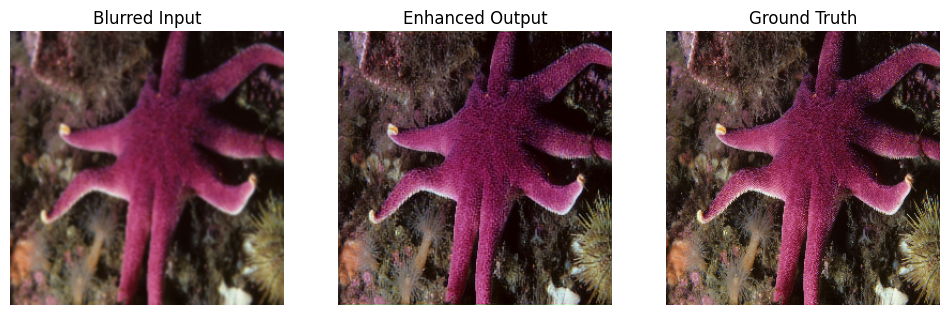

SSIM Score for sample 2: 0.8796


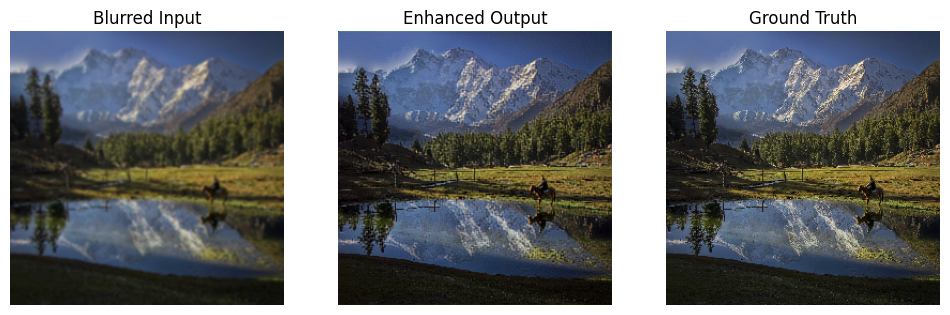

SSIM Score for sample 3: 0.9048


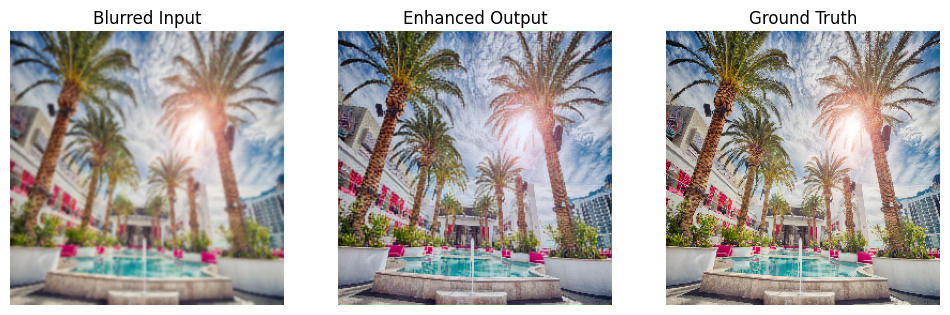

In [ ]:
from skimage.metrics import structural_similarity as ssim

model.eval()
with torch.no_grad():
    for i in range(3):
        lr, hr = dataset[i]
        inp = lr.unsqueeze(0).cuda()
        out = model(inp).clamp(0, 1).squeeze().cpu().permute(1, 2, 0).numpy()
        orig = hr.permute(1, 2, 0).numpy()
        blurred = lr.permute(1, 2, 0).numpy()

        # ✅ SSIM Score between output and ground truth
        ssim_score = ssim(out, orig, data_range=1.0, channel_axis=-1)
        print(f"SSIM Score for sample {i+1}: {ssim_score:.4f}")

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(blurred); plt.title("Blurred Input"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(out); plt.title("Enhanced Output"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(orig); plt.title("Ground Truth"); plt.axis("off")
        plt.show()


In [ ]:
import os
import glob
import time
import torch
import cv2

def measure_fps(model, device, test_image_path, num_runs=50):
    model.eval()
    img = cv2.imread(test_image_path)
    img = cv2.resize(img, (256, 256))
    input_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    input_tensor = input_tensor.to(device)

    # Warm-up
    for _ in range(10):
        with torch.no_grad():
            _ = model(input_tensor)

    start = time.time()
    for _ in range(num_runs):
        with torch.no_grad():
            _ = model(input_tensor)
    end = time.time()

    fps = num_runs / (end - start)
    print(f"✅ Model Inference Speed: {fps:.2f} FPS")
    return fps

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is on the correct device
model = model.to(device)

# Run this after training
test_img_path = glob.glob(os.path.join(LR_DIR, "*.png"))[0]  # Use first LR image
_ = measure_fps(model, device, test_img_path)


✅ Model Inference Speed: 113.99 FPS
